# Identifikation von Texten mit geteilter Autorenschaft

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Exploration:-booksummaries" data-toc-modified-id="Data-Exploration:-booksummaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Exploration: booksummaries</a></span><ul class="toc-item"><li><span><a href="#Extracting-Genres" data-toc-modified-id="Extracting-Genres-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Extracting Genres</a></span></li><li><span><a href="#Wieviele-Autoren-haben-in-wievielen-unterschiedlichen-Genres-publiziert?" data-toc-modified-id="Wieviele-Autoren-haben-in-wievielen-unterschiedlichen-Genres-publiziert?-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Wieviele Autoren haben in wievielen unterschiedlichen Genres publiziert?</a></span></li><li><span><a href="#Wieviele-Autoren-haben-wieviele-unterschiedliche-Bücher-publiziert?" data-toc-modified-id="Wieviele-Autoren-haben-wieviele-unterschiedliche-Bücher-publiziert?-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Wieviele Autoren haben wieviele unterschiedliche Bücher publiziert?</a></span></li><li><span><a href="#Doppelbelegung-von-Titeln" data-toc-modified-id="Doppelbelegung-von-Titeln-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Doppelbelegung von Titeln</a></span></li></ul></li><li><span><a href="#Mixing-Plots" data-toc-modified-id="Mixing-Plots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Mixing Plots</a></span><ul class="toc-item"><li><span><a href="#Generate-Binary-Genre-Vectors-per-book" data-toc-modified-id="Generate-Binary-Genre-Vectors-per-book-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate Binary Genre Vectors per book</a></span></li><li><span><a href="#Similarity-Measures" data-toc-modified-id="Similarity-Measures-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Similarity Measures</a></span><ul class="toc-item"><li><span><a href="#Cosine-Similarity" data-toc-modified-id="Cosine-Similarity-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Cosine-Similarity</a></span><ul class="toc-item"><li><span><a href="#Similarity-Matrix" data-toc-modified-id="Similarity-Matrix-2.2.1.1"><span class="toc-item-num">2.2.1.1&nbsp;&nbsp;</span>Similarity Matrix</a></span></li></ul></li></ul></li><li><span><a href="#Construction-of-artificial-texts-with-shared-authorship" data-toc-modified-id="Construction-of-artificial-texts-with-shared-authorship-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Construction of artificial texts with shared authorship</a></span><ul class="toc-item"><li><span><a href="#Combinatoric-considerations" data-toc-modified-id="Combinatoric-considerations-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Combinatoric considerations</a></span></li><li><span><a href="#Building-a-dataset" data-toc-modified-id="Building-a-dataset-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Building a dataset</a></span></li><li><span><a href="#The-simple-case" data-toc-modified-id="The-simple-case-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>The simple case</a></span></li></ul></li><li><span><a href="#Helpers" data-toc-modified-id="Helpers-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Helpers</a></span></li></ul></li></ul></div>

## Data Exploration: booksummaries

Basic data exploration of the booksummaries dataset.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals.joblib import Memory

Initialize Memory

In [2]:
memory = Memory(location='./tmp', verbose=0)

Loading the data

In [3]:
@memory.cache
def load_raw_data():
    return pd.read_csv(
        './datasets/booksummaries/booksummaries.txt', 
        header=None,
        sep='\t',
        names=['wiki_id', 'firebase_id', 'title', 'author', 'pub_date', 'genres', 'plot'],
        dtype={
            'wiki_id': 'uint32',
            'author': 'category'
        }
    )

In [4]:
data = load_raw_data()

In [6]:
# Number of entries
data.shape

(16559, 7)

In [11]:
# Entries are unique books by ids...
print("Unique Wikipedia IDs:\t", data.wiki_id.unique().size)
print("Unique Firebase IDs:\t", data.firebase_id.unique().size)
# ...but not by title
print("Unique Titles:\t\t", data.title.unique().size)
print("Unique Authors:\t\t", data.author.unique().size)
print("Unique Pub. Dates:\t", data.pub_date.unique().size)

Unique Wikipedia IDs:	 16559
Unique Firebase IDs:	 16559
Unique Titles:		 16277
Unique Authors:		 4715
Unique Pub. Dates:	 2640


In [8]:
# We have some missing values
data.isnull().sum()

wiki_id           0
firebase_id       0
title             0
author         2382
pub_date       5610
genres         3718
plot              0
dtype: int64

### Extracting Genres

In [ ]:
# Subset original data
temp = data.loc[:, ['wiki_id', 'genres']]
# drop rows without genres
temp = temp.dropna()
# extract `id: genre` pairs to lists
temp.genres = temp.genres.str.replace('[{}"]', '', regex=True).str.split(', ')
# map each genre <=> book relation to a seperate row
genre_tags = []
for key, row in temp.iterrows():
    book_id = row[0]
    tags = pd.Series(row[1]).str.split(': ')
    for genre_id, genre_name in tags:
        genre_tags += [[book_id, genre_id, genre_name]]


genre_tags = pd.DataFrame(genre_tags)
genre_tags.columns = ['wiki_id', 'genre_id', 'genre_name']

In [ ]:
# Extract unique genres
genres = genre_tags.groupby(['genre_id', 'genre_name']).agg('count')
genres.columns = ['count']
genres.describe() # Note that there are more unique ids than names ("Mystery" genre)

In [6]:
# Top 10 Genres
genres.sort_values('count', ascending=False)[0:10]

,,count
genre_id,genre_name,
/m/02xlf,Fiction,4747
/m/014dfn,Speculative fiction,4314
/m/06n90,Science Fiction,2870
/m/05hgj,Novel,2463
/m/01hmnh,Fantasy,2413
/m/0dwly,Children's literature,2122
/m/02n4kr,Mystery,1395
/m/03mfnf,Young adult literature,825
/m/0c3351,Suspense,765


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effcb9ebc18>]], dtype=object)

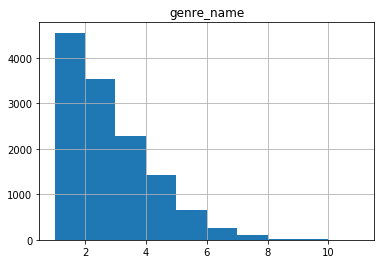

In [7]:
# Number of genres per book
genre_tags.loc[:,['wiki_id', 'genre_name']].groupby('wiki_id').count().hist()

In [5]:
def genres_for_books(wiki_ids):
    return genre_tags.loc[genre_tags['wiki_id'].isin(wiki_ids)]

# Look up multiple books
# genres_for_books(data.wiki_id.iloc[0:3])
# To look up single book wrap in an array
# genres_for_books([data.wiki_id[0]])

In [6]:
def genres_for_author(author):
    books_for_author = data.loc[data['author'] == author].loc[:, 'wiki_id']
    return genres_for_books(books_for_author)

# Look up genres for single author
# genres_for_author('George Orwell')

### Wieviele Autoren haben in wievielen unterschiedlichen Genres publiziert?

In [10]:
authors = data.groupby('author')

author_genres = []
for name, group in authors:
    author_genres += [
        [name, genres_for_books(group.wiki_id).genre_name.unique().size]
    ]

author_genres = pd.DataFrame(author_genres)
author_genres.describe()

,1
count,4714.000000
mean,2.441451
std,2.489543
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,22.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effcb9fa828>]], dtype=object)

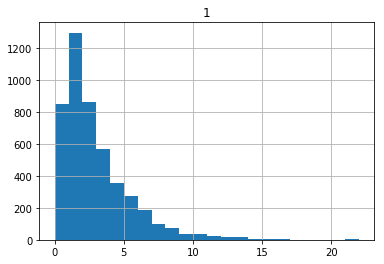

In [11]:
author_genres.hist( bins=22 )

### Wieviele Autoren haben wieviele unterschiedliche Bücher publiziert?

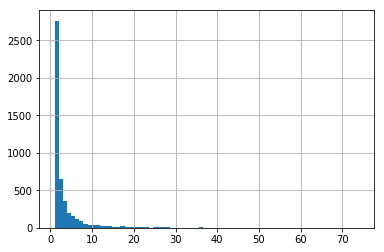

In [17]:
num_titles_per_author=authors.title.nunique()
plt=num_titles_per_author.hist(bins=num_titles_per_author.max())

In [18]:
print(num_titles_per_author.describe())

count    4714.000000
mean        3.006364
std         5.098350
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        74.000000
Name: title, dtype: float64


### Doppelbelegung von Titeln

In [19]:
titles=data.groupby("title")
print('Anzahl der doppelten Titeln:',titles.nunique().loc[titles.nunique().wiki_id > 1].shape)

Anzahl der doppelten Titeln: (246, 7)


In [20]:
titles.nunique().loc[titles.nunique().wiki_id > 1].head()

,wiki_id,firebase_id,title,author,pub_date,genres,plot
title,,,,,,,
1945,2,2,1,2,2,2,2
A Casa,2,2,1,2,0,2,2
A Taste for Death,2,2,1,2,1,2,2
Abduction,2,2,1,2,2,2,2
American Beauty,2,2,1,2,2,1,2


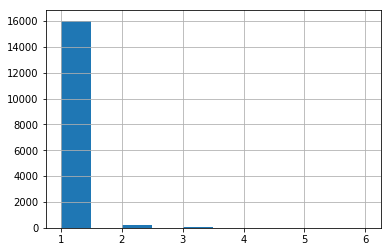

In [21]:
titles.nunique().wiki_id.hist()

## Mixing Plots

### Generate Binary Genre Vectors per book

In [7]:
# Extract k-hot-encoding of genres
@memory.cache
def extract_genres(data):
    result = data.genres.str.replace('[{}"]', '', regex=True) \
                         .str.replace('/m/.+?: ', '', regex=True) \
                         .str.get_dummies(', ')
    # Prefix and normalize genre columns
    result.columns = ['genre_' + str(col) for col in result.columns.str.lower().str.replace('[^a-z]', '_')]
    # Select genres that have been assigned at least twice.
    # 
    # Assuming we use genres only to match text an additional dimensions 
    # that is never shared will only make a text more 'different' from 
    # all other text. No information gain in that.
    # 
    # This reduces genres from 227 to 183. 
    result = result.loc[:, result.sum(axis=0) >= 2]
    
    return result

### Similarity Measures

#### Cosine-Similarity

The cosine similarity indicates similarity of orientation of two vectors by measuring the cosine of the angle between those vectors. Magnitude of the vectors is not of relevance. The cosine similarity is 0 for orthogonal vectors, 1 for vectors of the same orientation or -1  for diametrically opposed vectors.

$$ similarity: S_C(x,y) = cos(\pmb x, \pmb y) = \frac {\pmb x \cdot \pmb y}{||\pmb x|| \cdot ||\pmb y||} $$

As we are using the cosine similarity to compare attribute vectors in strictly positive space we can use the cosine distance, which is the complement of the cosine similarity in positive space. A distance of 0 indicates same orientation, a distance of 1 indicates no similarity or decorrelation and values in between indicate similarity or dissimilarity.

$$ D_C(x,y) = 1 - S_C(x,y) $$

##### Similarity Matrix

We calculate pairwise cosine similar for our books binary genre vectors.

In [8]:
@memory.cache
def calc_cosine_sim_matrix(genres):
    result = cosine_similarity(genres)
    result[np.tril_indices(result.shape[0])] = np.nan
    result = pd.DataFrame(result).apply(pd.to_numeric, downcast='float')
    return result

In [9]:
@memory.cache
def calc_cosine_dist_matrix(genres):
    return (calc_cosine_sim_matrix(genres) * -1.0) + 1.0

In [12]:
sim_matrix = calc_cosine_sim_matrix(extract_genres(data))

### Construction of artificial texts with shared authorship

As there is no labeled dataset of texts with shared and non-shared authorship (or at least non we know of), we have to construct a labeled dataset by artificially combining texts, then treating them as text of shared authorship and mix them with texts that have not been altered and are therefore considered to be of a non-shared authorship.

#### Combinatoric considerations

While combining texts for mixed authorship there are several factors that can be considered and varied to create different datasets that might effect the results later.

__Degree of similarity__  
By varying a threshold of similarity we assume that the difficulty of resulting combinations can be effected. Determining shared authorship of texts that are more alike by any given measure upfront, might be more difficult to detect than with a combined text of which original texts were considered less alike upfront.

__Reuse of texts__  
A text that was used for combination could be or not be reused for combination with additional texts or it could also be not be used as a text of non-shared authorship in the same dataset.

__Method of combination__  
There are different ways to combine texts. The simplest being to append on text to another. Another approach could be to split individual texts into paragraphs or sentences and interleave or randomly mix those tokens.
  
__Number of texts being combined__  
Any number of texts could be combined to create texts of shared authorship with different degrees, e.g. 1 to n authors.
  
__Share of combined texts in the resulting dataset__  
Depending on used features and techniques the percentage of shared texts vs texts of single authorship might effect the algorithms performance for new unrelated datasets.

#### Building a dataset

In [14]:
def build_dataset(
    # The dataset 
    data,
    sim_matrix,
    sim_threshold = 0.5,
    reuse_texts = False,
    combination = 'append',
    comb_degree = 2,
    target_share = 0.2,
    text_col = 'plot'
):  
    if comb_degree > 2:
        raise NotImplementedError
    # Total number of available texts
    n_total = data.shape[0]
    # Instantiate number of texts that will be combined
    n_combine = 0
    # Calculate number of combined texts
    if (reuse_texts):
        raise NotImplementedError
    else:
        # Number of texts that will be combined
        n_combine = n_total * comb_degree / (1/target_share + comb_degree - 1)
    
    # `n_combine` should be an integer value and dividable by `comb_degree` and
    # we will interpret target_share as minimum.
    n_combine = math.ceil(n_combine)
    n_combine += (n_combine % comb_degree)
    
    
    # Instantiate number of resulting combined texts
    n_combined = int(n_combine / comb_degree)
    # Number of texts that will directly be taken into the in the final dataset without combination
    n_direct = n_total - n_combine
    
    # Number of resulting texts
    n_result = n_direct + n_combined
    actual_share = n_combined/n_result
    
    print('Total # of input texts: ', n_total)
    print('# of texts to combine: ', n_combine)
    print('# of resulting texts with shared authorship: ', n_combined)
    print('# of resulting texts without shared authorship: ', n_direct)
    print('Total # of resulting texts: ', n_result)
    print('Actual share of texts with shared authorship: ', actual_share)
    
    # override lower diagonal with nan to drop duplicates and self combination.
    # SHOULD BE DONE BEFORE PASSED TO THIS METHOD
    # sim_matrix[np.tril_indices(sim_matrix.shape[0])] = np.nan
    # dropping nan
    sim_df = sim_matrix.stack()
    # drop combinations below threshold and return left viable choices
    choices = sim_df[sim_df >= sim_threshold]
    
    to_combine = np.ndarray((n_combined), dtype=tuple)
    if reuse_texts:
        choices = choices.index.values
        to_combine = np.random.choice(choices, n_combined, replace=False)
    else:
        for i in range(to_combine.shape[0]):
            # choose random tuple
            choice = np.random.choice(choices.loc[choices.notna()].index.values)
            to_combine[i] = choice
            # drop all tuples including either choice
            choices.loc[[choice[0], choice[1]]] = np.nan
            choices.loc[:, [choice[0], choice[1]]] = np.nan

    tc_values = list(sum(to_combine,()))
    all_values = pd.Series(data.index.values)
    to_direct = all_values[~all_values.isin(tc_values)]
    
    # combine texts
    combined = pd.DataFrame([[append_texts(data, ids, text_col), 1] for ids in to_combine])
    direct = pd.DataFrame([[data[text_col][i], 0] for i in to_direct])
    
    result = pd.concat(
        [combined, direct],
        axis=0,
        ignore_index=True, 
        copy=False
    )
    
    result.columns = ['text', 'label']
    
    return result

In [11]:
def append_texts(data, ids, text_col = 'plot'):
    t = ""
    for i in range(len(ids)):
        t += data[text_col][ids[i]]
    return t

#### The simple case

To start with we will go with a simple case:

In [15]:
sim_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Columns: 16559 entries, 0 to 16558
dtypes: float32(16559)
memory usage: 1.0 GB


In [17]:
sample_size = 100 # data.shape[0]
dataset = build_dataset(data.iloc[0:sample_size], sim_matrix.iloc[0:sample_size, 0:sample_size])

Total # of input texts:  100
# of texts to combine:  34
# of resulting texts with shared authorship:  17
# of resulting texts without shared authorship:  66
Total # of resulting texts:  83
Actual share of texts with shared authorship:  0.20481927710843373


In [39]:
dataset.to_csv('../data/plots.csv', encoding='utf-8', doublequote=True)

### Helpers

In [13]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted(
    [(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars],
    key=lambda x: x[1], 
    reverse=True
)

[('sim_matrix', 1096802028),
 ('data', 83719140),
 ('Memory', 1184),
 ('NamespaceMagics', 888),
 ('append_texts', 136),
 ('build_dataset', 136),
 ('cosine_similarity', 136),
 ('genres_for_author', 136),
 ('genres_for_books', 136),
 ('var_dic_list', 136),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('stats', 80),
 ('getsizeof', 72),
 ('calc_cosine_dist_matrix', 56),
 ('calc_cosine_sim_matrix', 56),
 ('extract_genres', 56),
 ('load_raw_data', 56),
 ('memory', 56)]